# Lecture 4: Optimization

## Copyright
These notebooks, authored by Hussain Kazmi, are licensed under the AGPL License; you may not use this file except in compliance with the License. Notebooks are distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. Support from KU Leuven and InnoEnergy is gratefully acknowledged.

## Context

In this lecture, we will use an electrical battery to optimize energy demand in a building. The idea will be to charge the battery when prices are low and discharge it when they are high. The same methodology can be extended to optimize for a number of different objective functions. 

We will investigate a number of different optimization algorithms to achieve these objectives. Starting off with easy-to-understand, brute force search, we will establish a baseline for subsequent (hopefully smarter) optimization algorithms. The second optimization algorithm we will implement will be a genetic algorithm, which belongs to the class of derivative free optimizers and us consequently extremely versatile (these algorithms have been used to solve just about every optimization problem, ranging from resource routing to training neural networks). However, their flexibility comes at a cost: in many situations, it makes sense to utilize an optimization method which can make use of the special structure in the problem. To do so, we will formulate the optimization problem as a linear program.

However, before diving into code, we discuss some of the distinctions that arise in practice in optimization problems in the first section.

***

## Classifying optimization problems
Optimization problems can be classified in many different ways. Some of these include:

### Constrained vs. unconstrained optimization
An unconstrained optimization problem does not impose any constraints on the decision variables. Training a linear model, as we did in the previous lecture, is an example of unconstrained optimization (i.e. the parameters of the model can take on any value). A constrained optimization problem, on the other hand, is typically formulated with some constraints on the values the decision variables can take (e.g. non-negativity constraints, binary or integer value constraints etc.). Optimization problems in power systems generally involve constraints, stemming either from physical or user requirements.

### Convex vs. nonconvex optimization
Tyrrell Rockafellar once wrote that _the great watershed in optimization is not between linear and nonlinear problems, but between convex and nonconvex problems_. While convex problems can be solved efficiently up to very large problem sizes, this does not hold for nonconvex problems. A non-convex optimization problem is any problem where the objective or any of the constraints are non-convex, which means there can be multiple feasible regions. While linear programming is an example of a convex optimization problem, large nonconvex problems are typically solved either by convexification (e.g. linearization of constraints etc.) or using derivative-free algorithms (such as genetic algorithms). Gradient descent, commonly used to train neural networks, is another popular optimization algorithm . These techniques generally do not guarantee the optimal solution, and it is likely that the solution they return is a local optima.

### Centralized vs. distributed optimization
Historically, power systems were treated as monolithic centrally planned systems. The system frequency was maintained by modulating the generation capacity of a limited number of electricity producers constrained on their operational costs, prevailing grid codes and inherent flexibility. However, with increasing proliferation of distributed energy resources (DERs), this paradigm no longer holds true. Therefore, in many cases it is important to solve the optimization problem in distributed fashion, i.e. at each node, rather than centrally. This has important implications for the amount of data and information that needs to be transferred as well as the quality of the solution that can be obtained at the end.

### Deterministic vs. stochastic optimization
Typically, optimization is carried out with forecasts for the future. Where there is uncertainty associated with these forecasts (e.g. in the case of electricity demand and supply), it is important to take this information into consideration during the optimization process. This is the difference between deterministic and stochastic optimization. Here we use stochastic optimization to refer to the large family of algorithms which enable decision making under uncertainty, including robust optimization, stochastic programming etc.

### Single-objective vs. multi-objective optimization
Finally, while many optimization problems require a single objective to be optimized, often times we are interested in optimizing for multiple objectives. In some instances, it is possible to combine these different objectives into a single objective function (e.g. by computing some sort of weighted average, and then using that as an objective function), but this is not always desirable. In such cases, we can consider the Pareto front of solutions, which reflect all possible non-dominated solutions, i.e. picking one solution over another will reduce the objective function value in some way. In this lecture, we will cover two different objective functions separately, but combining them will be left to the reader.

### Model-based vs. model-free optimization
Model predictive control forms a large part of optimal control literature in energy grids. This method makes use of models (e.g. for demand or supply etc.) to forecast into the future. Then certain variables are manipulated to minimize the cost of these future scenarios. On the other hand, model-free algorithms learn the optimal control actions directly from the system and agent states. Depending on how difficult it is to obtain an accurate model of the system, model-free methods may be preferred over model-based ones. Many reinforcement learning algorithms (e.g. Q-learning, Deep Q-Networks, etc.) are examples of model-free methods. In this lecture, we will focus exclusively on model-based algorithms.


***

## Formulating and solving an optimization problem

### Elements of an optimization problem
In general, a constrained optimization problem consists of three key elements:
1. Variables: these can either be decision variables i.e. those that can be manipulated in the optimization process or defined variables, i.e. those that cannot be modified.
2. Constraints: these define any constraints that are imposed on the values the decision variables may or may not take (e.g. non-negativity, integer values etc.)
3. Objective function: this specifies the metric we would like to optimize for. It is also known as the cost function and fitness function, depending on the field of study.

### Examples

Some common optimization examples in smart grids include the following objective functions:
1. Minimizing peak demand
2. Minimizing energy demand
3. Minimizing grid electricity costs and/or emissions (using a battery-inverter system)
4. Minimizing multiple such objectives at the same time

All of these objectives need to be achieved while preserving user comfort. Practically, they can be realized using energy flexible resources (EFRs) such as storage systems e.g. electric batteries, hot water vessels etc. It is also possible to modulate the electricity being produced by renewable sources such as solar PV (e.g. through curtailment) or by shifting the energy demand of certain white goods (e.g. dishwashers, washing machines etc.).

***

## Minimizing grid electricity costs

In the first part of this lecture, we will take a look at minimizing the electricity usage prices based on cost arbitrage (buy-low-sell-high) with an electrical battery-inverter system. We start off by importing necessary libraries and making sure that _matplotlib_ plots are legible.

In [ ]:
import numpy as np
!pip install deap
from deap import algorithms, base, creator, tools
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 15})

     |████████████████████████████████| 160 kB 10.7 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


### Defining demand and electricity prices

First, let us define some hypothetical electricity prices (to simplify our analysis - at the end of this lecture, we will revisit these electricity prices and make them more realistic). In this case, the price oscillates between a maximum and a minimum value multiple times in the day.

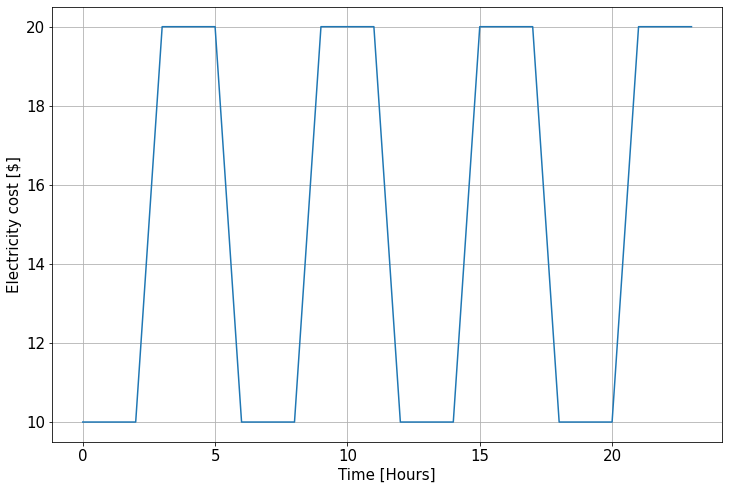

In [ ]:
price = np.array([10,10,10,20,20,20,10,10,10,20,20,20,10,10,10,20,20,20,10,10,10,20,20,20])

plt.plot(price)
plt.grid(True)
plt.xlabel('Time [Hours]')
plt.ylabel('Electricity cost [$]')
plt.show()

Now, let's also generate the demand for 24 hours in the same way! Note that in practice this will obviously be from the building or cluster of buildings you will analyze. 

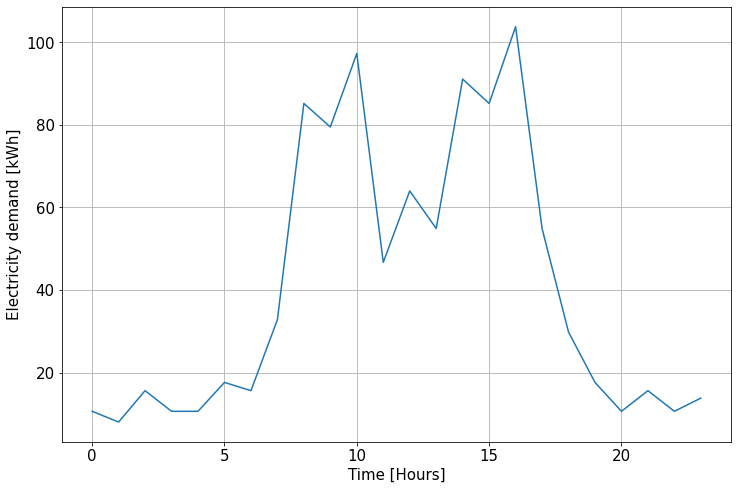

In [ ]:
demand = np.array([10.6,   8. ,  15.6,  10.6,  10.6,  17.6,  15.6,  32.8,  85.2,
        79.5,  97.3,  46.7,  64. ,  54.9,  91.1,  85.2, 103.8,  54.9,
        29.8,  17.6,  10.6,  15.6,  10.6,  13.8])

plt.plot(demand)
plt.grid(True)
plt.xlabel('Time [Hours]')
plt.ylabel('Electricity demand [kWh]')
plt.show()

Finally, let us define the battery and grid characteristics which form part of the environment and cannot be modified by the optimization framework. Note that here we are assuming an ideal battery model. In reality, your battery will suffer from losses every time you will discharge or charge it. Likewise, here we are not considering the longevity of the battery or the allowed depth of discharge. In practice, these are important considerations that need to be taken into consideration by the optimizer.

In [ ]:
batteryCapacity = 75 #kWh
inverterCapacity = 40 #kW
peakPowerLimit = 80 # kW

### Setting up the framework
Instead of directly starting off with formulating the optimization problem, it is instructive to consider a simpler approach to set up the baseline. This is what we did with the persistence model in the previous lecture. In this lecture, we will use a similarly simple algorithm: randomly sample a large number of potential solutions and choose the best one. The idea here is that it is extremely cheap to create and evaluate a solution, while it can be computationally challenging to find the exact optimal one. There are numerous ways to randomly generate schedules for charging and discharging a battery of course. In this lecture, we start off by using the _DEAP_ library, a versatile tool that also allows us to perform optimization in a more sophisticated manner.

As the first step, we create a new class that inherits from the base class. This is necessary to evaluate the objective function for a given solution. The negative sign with the _weights_ argument means that we are defining a minimization problem.

In [ ]:
creator.create("Fitness", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.Fitness)

Next, we create a toolbox that will eventually contain the characteristics we wish our solutions to possess.

In [ ]:
toolbox = base.Toolbox()

We now register an attribute generator in the toolbox we created. This generator can be any random integer between the rated power of the battery inverter, and it will be used to generate individual solutions (i.e. the battery charging and discharging schedule). The reason for using the _inverterCapacity_ as an argument here is to impose the constraint that our battery-inverter system cannot draw more power than it is physically allowed to.

In [ ]:
# Attribute generator
toolbox.register("attr_bool", np.random.randint, -inverterCapacity, inverterCapacity+1)

After registering the attributes, we can generate both individual solutions and also a population of such solutions to check how they look like.

In [ ]:
# Structure initializer
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, 24)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

print('A possible (not necessarily feasible) solution:')
print(np.array(toolbox.individual()))

print()
print('A population of possible (but not necessarily feasible) solutions')
np.array(toolbox.population(10))

A possible (not necessarily feasible) solution:
[-37  25 -17  31  32 -11 -37  30 -25   1 -21 -39  -6  -5  16 -16 -33  -1
  26  28  -5  40 -38   8]

A population of possible (but not necessarily feasible) solutions


array([[ 20,   9, -19, -40, -25, -16,  10, -29,  31, -26,  -1, -12, -13,
        -17, -25,  35,  24,  -2,   8,  18,   0, -35, -30,  -3],
       [ 33,   1,  21,  26, -32,   0,  18, -24,  38,   2,   5,  15,  17,
        -30,  10,  -8,  -3, -37,   1, -29,   8,  -2,  -2,   3],
       [ 34,   0,   8, -30,  12,   8,  31,   8,  -8,  27,  23, -29, -30,
         18,  20,  16, -13, -13,  -2, -24, -23, -38,  23,  15],
       [-21,  -5,  29,  -9, -26,  29,  -8, -23,  35,  25,  16, -20,  14,
        -38,   9,   0, -18, -14, -24,  29,  23, -37, -27,  15],
       [ 38,  23,  14, -30,  33, -12,   4, -36,  -3,  22, -17,  26, -36,
         28, -39,  28, -31,  -5, -19,  14, -27,   9, -37, -15],
       [  0,  13, -26,  -4, -33,   4, -28,  -2,  31,  -9,  14,  37, -33,
         17, -29, -13,  18,  12,  32, -20, -14, -39,  30,  24],
       [-30,  40,  31,  15,  27,   2, -13,   7, -20,  18,  15,  36, -38,
         40,  -5, -26,  38, -24,   4, -11,  14,  29, -31,  15],
       [ 27, -27, -32, -29,  19,  31,  19

At this point, we can define the cost function that we wish to minimize. As explained at the beginning of the section, this cost function should reflect the price of electricity and the electricity demand based on the battery usage. We assume, for now, that the excess electricity stored in the battery can be used either in the building to meet its energy demand, or sold back to the grid. As mentioned earlier, we also assume that the battery has 100% efficiency to keep things simple.

To ensure feasibility of solutions we place a very large penalty on battery violations in the cost function. A battery violation is when the battery is charged beyond its capacity (or alternatively discharged below 0 kWh). As this is a constrained optimization problem, it would make sense to formulate these as constraints. However, in many population based (or derivative free algorithms), it is commonplace to include the constraint in the objective function (with a high cost). This virtually acts as a relaxation of the constraint. 

You can theoretically also add the battery capacity (or any other systemic limitation) as a constraint. This includes longevity constraints for the battery (i.e. it must not be cycled more frequently than a threshold or the depth of discharge must not be greater than x% etc.)

In [ ]:
def cost_function_arbitrage(individual):
    cumsum = np.cumsum(individual)
    violations_battery = (np.sum(np.where(cumsum>batteryCapacity)) + np.sum(np.where(cumsum<0))) * 10000
    return np.sum(price*individual) + violations_battery,


Finally, we need to register the cost function we just created with the toolbox we had defined earlier.

In [ ]:
toolbox.register("evaluate", cost_function_arbitrage)

Make sure you understand the cost function and how the population is being created before going forward.

### Random guessing

Now we have all the tools to create a population with different solutions (drawn randomly) and evaluate them. Then, we can select the best one of the lot. We start off by generating a population of 100 solutions.

In [ ]:
numSolutions = 100
pop = toolbox.population(n=numSolutions)
cf = np.zeros(numSolutions)
mincf = np.zeros((numSolutions-1))
for i in range(numSolutions):
    cf[i] = cost_function_arbitrage(pop[i])[0]
    if i>0:
        mincf[i-1] = np.min(cf[0:i])

We can now check the quality of the best solution discovered by random search over time with increasing number of solutions (this is contained in the variable mincf). Remember that we are interested in minimizing the total energy cost so lower scores are better.

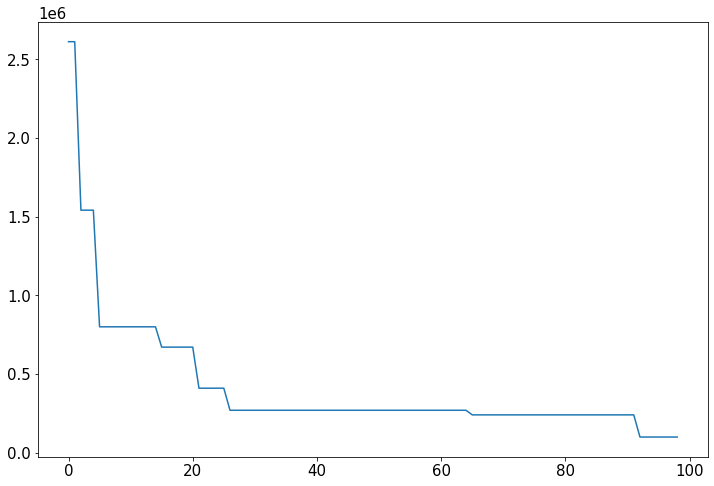

The minima found by random search after 100 attempts is: 100290.0


In [ ]:
plt.plot(mincf)
# plt.ylim(-3000,100)
plt.show()
print('The minima found by random search after ' + str(numSolutions) + ' attempts is: ' + str(np.min(mincf)))

It seems that the best minima found by random search is going down over time, however it is difficult to understand exactly what is happening with just this plot. Let us next define a helper function to visualize the solutions (including the best solution) we have obtained and compare it against desired behavior.

In [ ]:
def visualizeResults(solution):

    plt.plot(solution,'*-',label='Inverter demand')
    plt.plot(demand,label='Building energy demand')
    plt.plot(price,'o--',label='Price [$]')
    plt.grid(True)
    plt.xlabel('Time [h]')
    plt.ylabel('[kWh]')
    plt.legend()
    plt.title('Best solution overlaid with building energy demand and prices')
    plt.show()

    plt.scatter(price, solution)
    plt.xlabel('Price [$]')
    plt.ylabel('Inverter power [kW]')
    plt.grid(True)
    plt.title('Charge/Discharge operation as a function of electricity prices')
    plt.show()
    
    plt.plot(demand + solution)
    plt.xlabel('Time [h]')
    plt.ylabel('Total grid demand')
    plt.grid(True)
    plt.title('Total electricity demand on the grid')
    plt.show()


Now, let's visualize the best result we have discovered through random sampling.

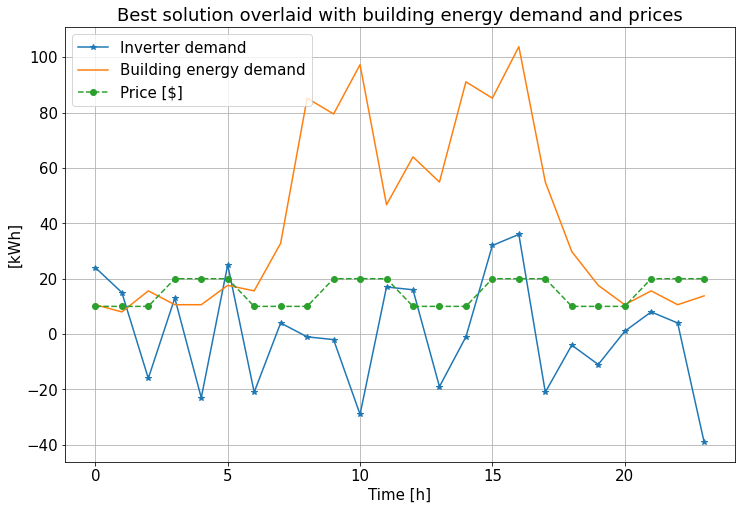

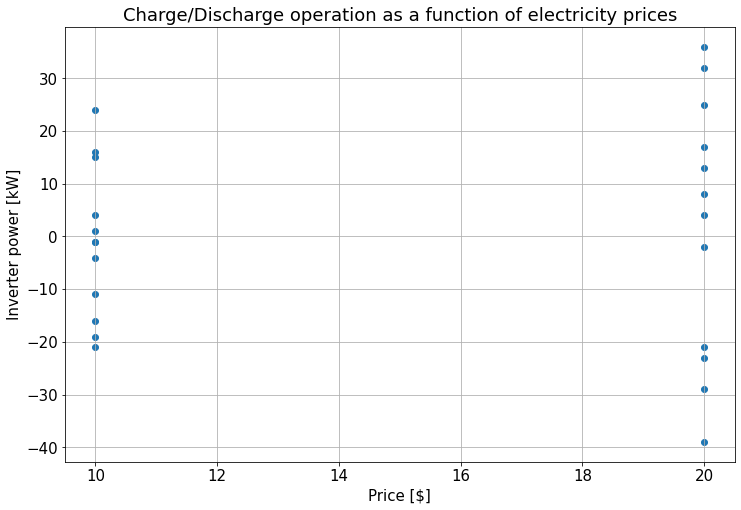

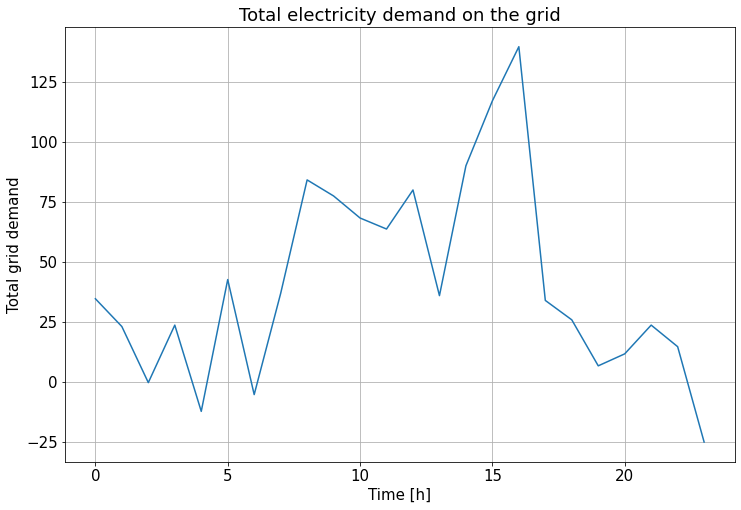

In [ ]:
minIndex = np.argmin(cf)
visualizeResults(pop[minIndex])

From these results, it should be obvious that we are not doing particularly well. The battery seems to be charging even when the prices are high, and discharging when the prices are low. This is obviously not optimal behaviour but it should be hardly surprising due to the extremely simplistic nature of the search policy. 

#### Exercises
1. Owing to the simple electricity pricing funciton we have used, we can however derive the optimal charging profile by hand. What is this optimal (minimum) value of the objective function, by considering the price and battery capacity? How far is the best solution you have found so far from this value?
2. What happens to the cost function as you increase the number of solutions you are randomly sampling? Evaluate 1000 and 10000 solutions to see how this increases. Average multiple runs to obtain statistically relevant results.

### Setting up genetic algorithms
Instead of a brute force search which retains no memory and therefore draws all solutions independently, it is possible to either optimize this problem using linear programming or a 'smart' search based method. This latter (smarter search) includes strategies such as simulated annealing, population based methods (such as genetic algorithms, ant colony optimization) and tabu search etc. Here, we dig deeper into using genetic algorithms to discover the optimal charging and discharging profile of the battery. In a subsequent section, we also explore how to solve this problem optimally.

Genetic algorithms offer a large number of levers to play with to discover optimal solutions (you can also think of these as hyperparameters to the algorithm). As a member of the broader family of algorithms known as metaheuristics, these algorithms are usually known to only approximate the optimal solution (i.e. they do not guarantee the global optima, but oftentimes converge to a local optima). However, they are often extremely versatile tools to discover good enough solutions to many practical problems of interest. Furthermore, they are anytime algorithms, which means they do not need to be run till convergence and the search can be stopped at any point in time to retrieve the best solution that has been discovered so far. In this section, we briefly cover some of the theory of genetic algorithms, before applying them to the problem of cost arbitrage.

#### Initialization
Genetic algorithms are population based methods, so they work with a large population of individuals, often initialized randomly. This population is then evolved in a way that its fitness improves over time. Genetic algorithms try to search for the global optima, which means that, in the short term, the fitness of the population may go down to avoid getting trapped in a local optima.

#### Selection 
Genetic algorithms require a selection process to be defined that can be used to give preference to fitter individuals in the population in the evolutionary process.

#### Crossover
Genetic algorithms work by taking multiple individual solutions and combining them to form a new individual. This is known as crossover. Examples of such a crossover operation include one-point crossover and edge recombination. The idea behind this operation is to combine the best possible solutions discovered so far to enable discovery of even better solutions.

#### Mutation
Genetic algorithms also evolve the population by introducing new traits (i.e. diversity) using mutation. The idea of this operator is to search for better solutions by varying elements of already discovered solutions in a controlled manner.

Both mutation and crossover, combined with selection, ensure that genetic algorithms retain history over time and therefore continuously evolve towards an improved solution. This is in contrast to the brute force search we encountered earlier, which did not have this iterative element to it.

#### The brains of the operation
At the end of the day, with a lot of these algorithms, you need to assign credit for finding a good solution. This can lie (1) with the algorithm, (2) with the programmer designing (and implementing) the algorithms, or (3) with the solution space (or the problem itself). Often, in simple Genetic Algorithm approaches, it is the latter two, as the algorithm itself is not 'particularly' smart or clever. However, with increasing compute power, it provides surprisingly good results. Furthermore, as the search algorithm remains the same regardless of the objective function, GA can scale seamlessly, by considering even non-convex problems with multiple objective functions.

The first step to explore genetic algorithms for our problem, using in-built DEAP functionality, is therefore to define the crossover, mutation and selection processes. For more practical information on using genetic algorithms, check out the DEAP documentation. For a high level but slightly more technical overview, see [here](https://www.youtube.com/watch?v=wiQOsH8C-uQ&t=936s) and [here](https://www.youtube.com/watch?v=kHyNqSnzP8Y).  An excellent, highly recommended description of evolutionary algorithms is presented in this [visual guide](http://blog.otoro.net/2017/10/29/visual-evolution-strategies/).

In [ ]:
toolbox.register("mate", tools.cxTwoPoint) # crossover
toolbox.register("mutate", tools.mutUniformInt, low=-inverterCapacity, up=inverterCapacity, indpb=0.2) # mutation
toolbox.register("select", tools.selTournament, tournsize=3) # selection 


Next, we initialize a population of 10,000 offspring (individual solutions). These are created randomly according to the rules we specified at the start of this section. Chances are therefore high that most, if not all, of these solutions will be unfeasible and will therefore have extremely poor fitness values (as before, with the brute force search).

In [ ]:
pop = toolbox.population(n=10000)

Now, we can initialize the hall of fame, aka a bunch of solutions which have outperformed all other solutions that we have encountered so far.

In [ ]:
hof = tools.HallOfFame(10)

And finally, before running the genetic algorithm itself, we would like to create the metrics which allow us to evaluate not just the best solution found so far (which is done through the fitness function), but also the fitness function values of the entire population (we are particularly interested in these values as we want there to be enough diversity in our solutions, especially at initialization)

In [ ]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

With everything defined, we can set the genetic algorithm in motion now!

In [ ]:
# Single objective case
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.5, ngen=10, stats=stats, halloffame=hof,  verbose=True)


gen	nevals	avg          	std              	min    	max       
0  	10000 	[1939571.443]	[756925.67689607]	[-480.]	[2762320.]
1  	7462  	[1540844.253]	[754451.72326468]	[-1500.]	[2760950.]
2  	7476  	[1360068.234]	[768227.58539475]	[-840.] 	[2762200.]
3  	7600  	[1275119.753]	[790721.59035207]	[-840.] 	[2761800.]
4  	7466  	[1225265.977]	[810699.72430084]	[-840.] 	[2762130.]
5  	7537  	[1189687.043]	[819344.13163995]	[-810.] 	[2760770.]
6  	7450  	[1152040.367]	[837461.28241845]	[-1470.]	[2764570.]
7  	7574  	[1131326.871]	[839908.92683236]	[-1380.]	[2760990.]
8  	7396  	[1111377.892]	[841410.33654046]	[-970.] 	[2761940.]
9  	7481  	[1094730.143]	[852912.14545867]	[-1130.]	[2761980.]
10 	7454  	[1086341.821]	[853754.98365011]	[-1340.]	[2760930.]


In this case, we ran our genetic algorithm for 10 number of generations (_ngen_). As you increase the number of generations, the solution quality should improve - which is something you can verify by running the GA for a bigger number of generations. 

Now, we can use the visualization function we defined previously to visualize the best solution (contained in the hall of fame) that we have discovered so far!

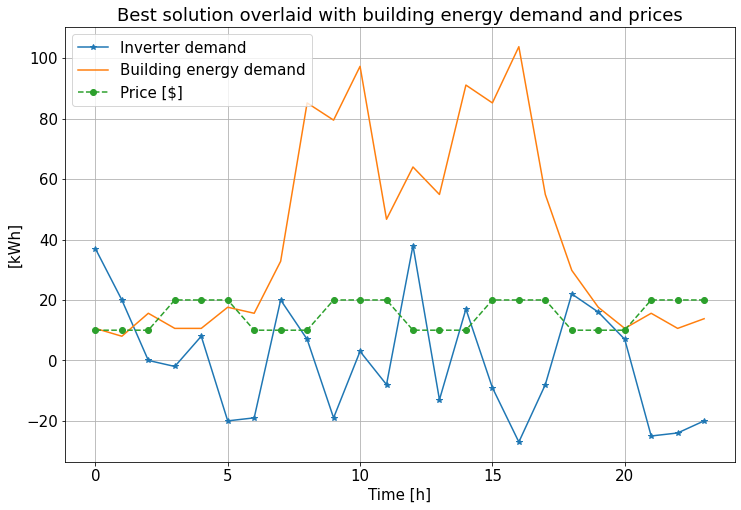

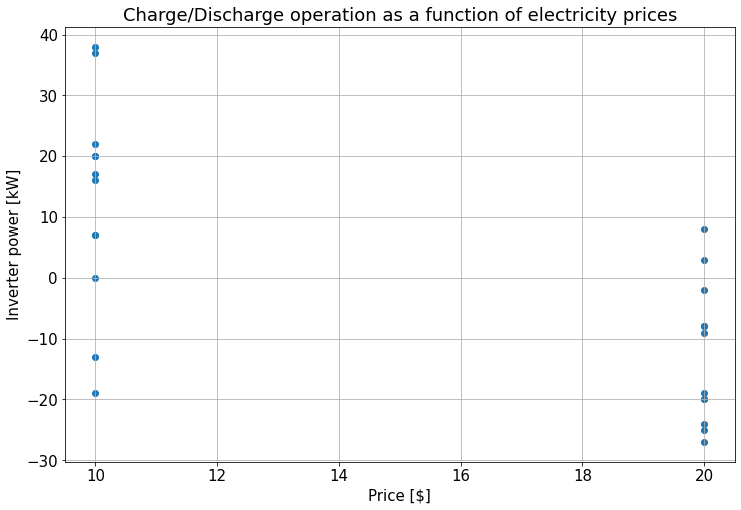

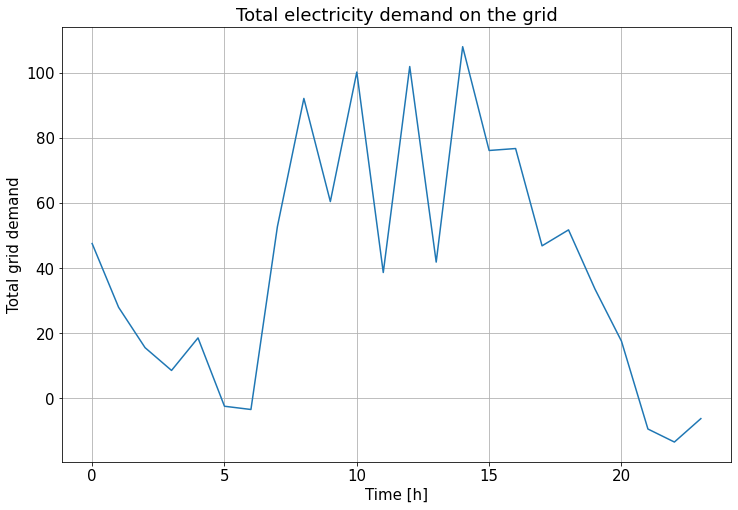

In [ ]:
visualizeResults(hof[0])

We can also visualize the different solutions in the hall of fame to see if they are all different or similar!

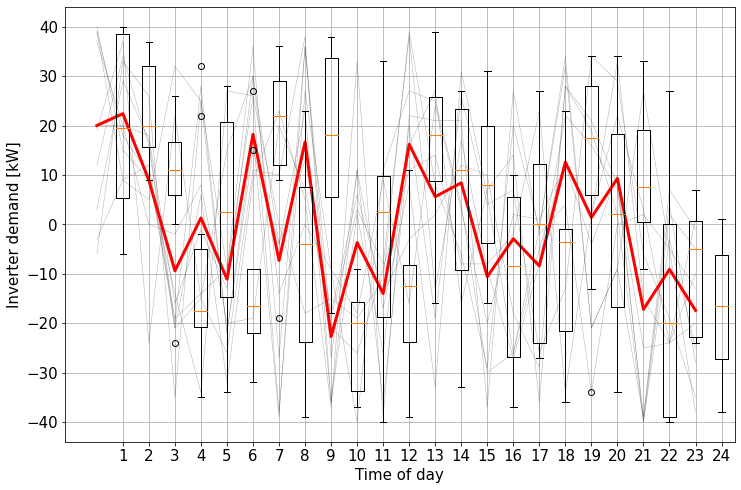

In [ ]:
plt.plot(np.array(hof).T,'black',alpha=.3,linewidth=0.5)
plt.plot(np.mean(np.array(hof).T,1),'red',linewidth=3)
plt.boxplot(np.array(hof))
plt.xlabel('Time of day')
plt.ylabel('Inverter demand [kW]')
plt.grid(True)
plt.show()

#### Exercises
1. How does the GA compare with the random brute-force method we evaluated earlier? 
2. How close does the optimal solutionm from the GA get to the optimum value you calculated earlier?
3. What is the influence of the number of generations and population size on the solution quality?
4. Change the GA specific hyperparameters (crossover and mutation probability) to see if you can improve the solution quality.

### Linear programming

So far, in this lecture, we have focused exclusively on the DEAP library for both brute force search and also for genetic algorithms. While this is an extremely flexible and versatile library that can be used to optimize for a number of different objective functions, there are other players in the game as well. These include both convex and non-convex optimizers. For non-convex solvers, Nevergrad is a popular open-source library from Facebook which has a large number of underlying algorithms. Likewise, Pulp and Pyomo are two popular candidates for convex optimization. In this section, we show how you can use Pulp to solve the same problem exactly. We begin by importing Pulp.

In [ ]:
!pip install pulp
import pulp

     |████████████████████████████████| 40.6 MB 14.6 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


Next we create a list of time points when a decision needs to be made and create a dictionary which contains prices at those time points. Finally, as part of the boiler plate code, we create a variable for every point in time.

In [ ]:
# Create a list of time points when decision needs to be taken
time_points=[str(i) for i in range(len(demand))]

# Create dictionary holding prices at the time points
price_dict = dict(zip(time_points, price))

# Create a variable for every point in time
time_point_vars=pulp.LpVariable.dict("solution",time_points,-inverterCapacity,inverterCapacity)

Next, we define the optimization problem as a minimization problem.

In [ ]:
# Define the problem as minimization
prob = pulp.LpProblem("myProblem", pulp.LpMinimize)
prob += pulp.lpSum([time_point_vars[i]*price_dict[i] for i in time_points])

The next step is to add constraints. Notice how now we are specifying constraints differently as opposed to before.

In [ ]:
# Add constraints
for j in range(len(time_points)):
    # At every point in time the cumulated charge/discharge needs to be within bounds
    prob += pulp.lpSum([time_point_vars[i] for i in time_points[:j+1]]) <= batteryCapacity
    prob += pulp.lpSum([time_point_vars[i] for i in time_points[:j+1]]) >= 0

Now that the optimization problem has been formulated, we can solve it, and print and visualize the results.

Welcome to the CBC MILP Solver 
Version: 2.9.0 
Build Date: Feb 12 2015 

command line - /root/venv/lib/python3.7/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/25fdff09d40a4bc0bec8a04058001cca-pulp.mps branch printingOptions all solution /tmp/25fdff09d40a4bc0bec8a04058001cca-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 53 COLUMNS
At line 678 RHS
At line 727 BOUNDS
At line 776 ENDATA
Problem MODEL has 48 rows, 24 columns and 600 elements
Coin0008I MODEL read with 0 errors
Presolve 46 (-2) rows, 24 (0) columns and 598 (-2) elements
Perturbing problem by 0.001 % of 20 - largest nonzero change 0.00018650558 (% 0.0018650558) - largest zero change 0
0  Obj -14000 Primal inf 11040 (23)
16  Obj -3000
Optimal - objective value -3000
After Postsolve, objective -3000, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -3000 - 16 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU se

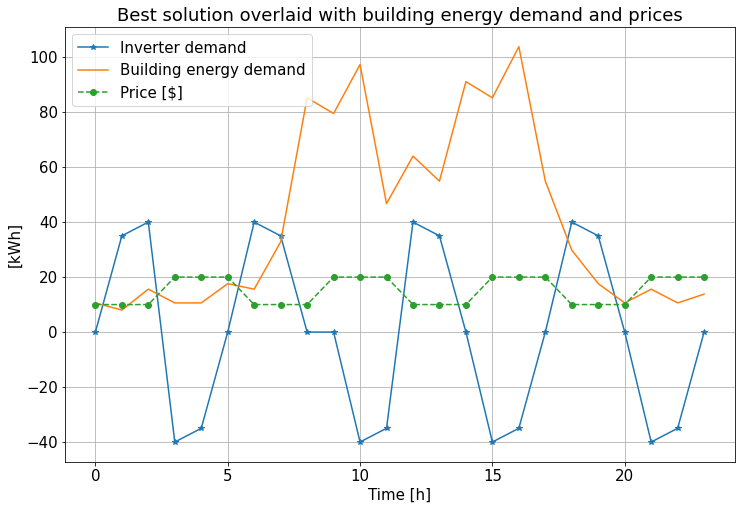

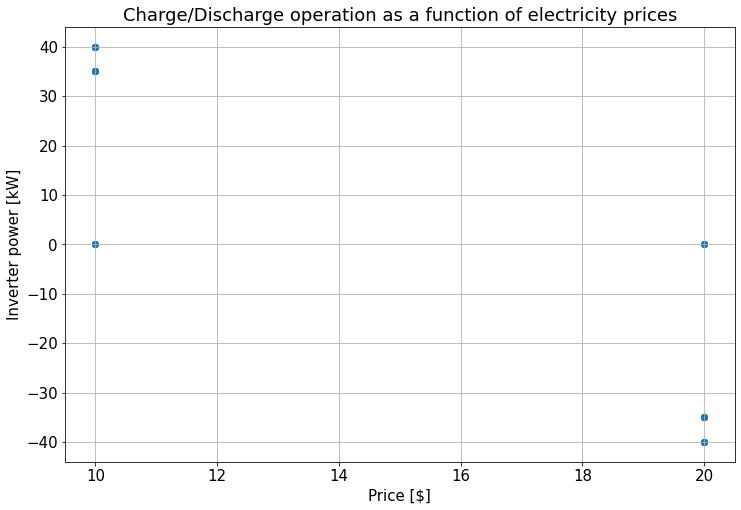

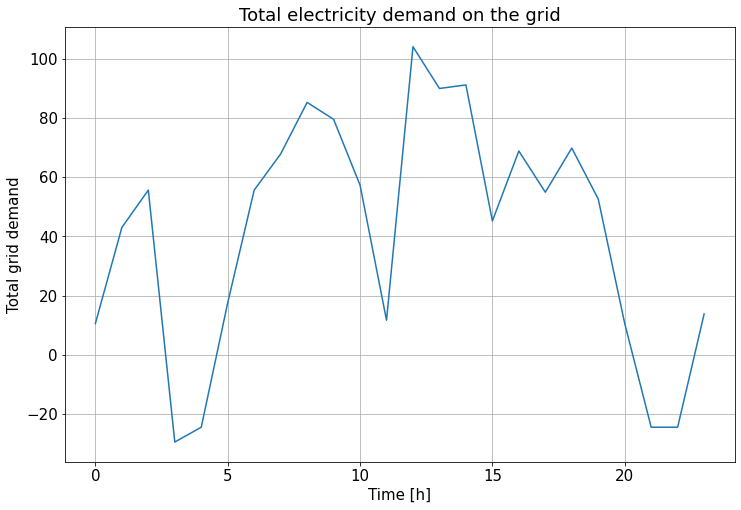

In [ ]:
# Solve
prob.solve()
# Print result
print("Found minimum",prob.objective.value())
solution_dict = {}
for v in prob.variables():
    solution_dict[int(v.name.replace("solution_",""))] = v.varValue
# Now convert solution dictionary to a time-sorted list
solution=[]
for i in sorted (solution_dict) :
    solution.append(solution_dict[i])
visualizeResults(solution)

That was fast and exact! This should be a useful illustration of how you should always use the right tool for the right problem. 

## Working with different objective functions

Previously, we have specifically focused on using the battery-inverter system to provide cost arbitrage using price differences over the course of the day. This has assumed that the building energy demand can go negative, i.e. the controller is allowed to inject electricity back to the grid if it thinks this would be beneficial. Assuming that grid injection is not possible (or remunerated, as is often the case), we can change the cost function appropriately to discourage this quite easily. Returning to Deap, we do this easily by introducing an additional penalty term (_violations_demand_) in our cost function.

In [ ]:
def cost_function_arbitrage_constrained(individual):
    cumsum = np.cumsum(individual)
    violations_battery = (np.sum(np.where(cumsum>batteryCapacity)) + np.sum(np.where(cumsum<0))) * 10000
    
    tmp = demand+individual
    violations_demand = -np.sum(tmp[np.where(tmp<0)]) * 10000
    
    return np.sum(price*individual) + violations_battery + violations_demand,

We now need to register this new cost function, as before, and reinitialize both the population and the hall of fame.

In [ ]:
toolbox.register("evaluate", cost_function_arbitrage_constrained)
hof = tools.HallOfFame(10)

In [ ]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.5, ngen=100, stats=stats, halloffame=hof,  verbose=True)


gen	nevals	avg          	std              	min    	max       
0  	0     	[1083611.026]	[853986.58173476]	[-940.]	[2760990.]
1  	7527  	[1390724.167]	[993213.64280699]	[-730.]	[4324000.]
2  	7589  	[1405416.356]	[957263.22234824]	[-730.]	[3960030.]
3  	7386  	[1376951.238]	[935473.00021533]	[-730.]	[4063260.]
4  	7359  	[1360965.7]  	[920131.37872899]	[-730.]	[4064070.]
5  	7489  	[1352555.183]	[927277.57021018]	[-730.]	[4159450.]
6  	7548  	[1327025.609]	[923008.64641943]	[-730.]	[3920330.]
7  	7446  	[1298250.487]	[919354.2780067] 	[-730.]	[3967080.]
8  	7438  	[1263116.13] 	[912733.76054013]	[-730.]	[3994750.]
9  	7514  	[1236579.692]	[909939.01338881]	[-730.]	[4366210.]
10 	7480  	[1221264.212]	[923371.92167533]	[-730.]	[3775120.]
11 	7551  	[1185295.214]	[913522.54027517]	[-700.]	[3850260.]
12 	7452  	[1171792.44] 	[920924.27269493]	[-430.]	[3855170.]
13 	7488  	[1161643.538]	[924300.40750301]	[-430.]	[3802630.]
14 	7442  	[1140774.102]	[923896.99388033]	[-470.]	[3901630.]
15 	7478

As before, we can visualize the results of our optimization using the visualization function we defined earlier.

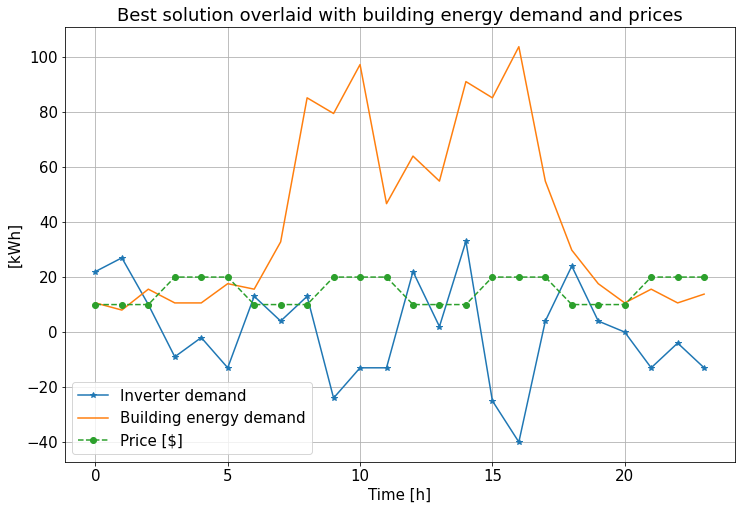

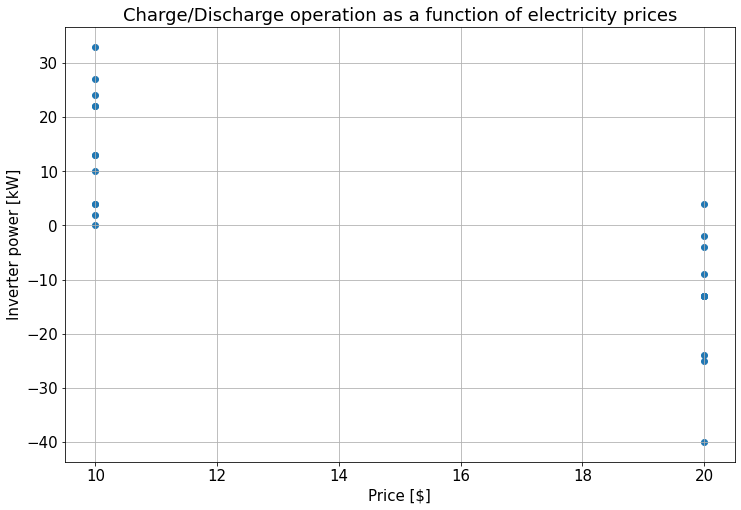

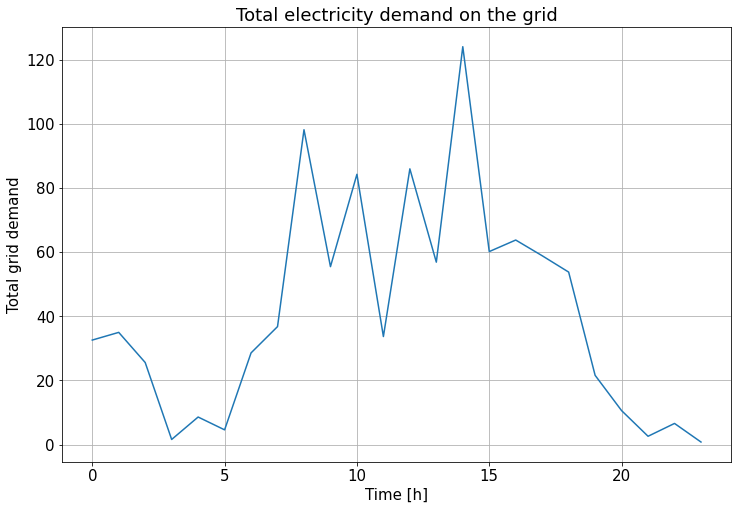

In [ ]:
visualizeResults(hof[0])

If the optimizer has done its job, we should see that the total building energy demand no longer goes below zero, while still reducing energy costs for the end user.

### Exercises

1. Devise a new objective function where you use the battery-inverter system to perform peak shaving, with the max allowable power demand in the building (building demand + battery demand) is 80 kW (instead of cost arbitrage). Plot the results and describe your findings.
2. Optional. Can you reformulate the two problems (constrained cost arbitrage and peak shaving) in Pulp.

***

## Extending to the real world

So far, we have worked with a fictitious demand profile and a fictitious price signal to simplify the concepts. Now, load the provided file 'OptimizationData.csv'. This file contains electricity demand in kWh and  price data in euros/MWh (from Belpex spot market), for around one whole year. 

### Exercises

1. As a first step, calculate the electricity cost with no battery (i.e. the sum of the element-wise product of demand and price). This gives you the baseline costs that your battery-inverter system must outperform.

2. Now, to calculate the value of flexibility, assume a bigger battery-inverter system than the one used in this lecture (750 kWh/100 kW). Using this battery-inverter system and assuming perfect knowledge of the demand/price data, perform constrained cost arbitrage on the day-ahead scale i.e. assume you optimize your daily energy demand at mid night for every day of the year. This will give you an optimized schedule of when to charge batteries and when to discharge them. How does the cost of electricity differ from the one you calculated in question 1? This gives you the theoretical upper bound of value you can create with the battery-inverter system over one year.

3. Replace the perfect forecast of demand by the best forecast you created in previous lectures (assume that the day-ahead price is still perfectly known). How does this effect the objective function (i.e. total cost of electricity demand) you are able to achieve after an entire year?


***

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b21ecfca-1024-46a4-860c-35a51c91b2b7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>